In [1]:
from training_data import import_training_set

data, weights, rulesetIds = import_training_set("components classification")

In [2]:
# Remove instances involving a Random agent

remove = data[["Selection 1 - Random", "Selection 2 - Random"]].any(axis=1)
# data = data[~remove]
# weights = weights[~remove]
# rulesetIds = rulesetIds[~remove]

In [3]:
data

,Selection 1 - ProgressiveHistory,Selection 1 - Random,Selection 1 - UCB1,Selection 1 - UCB1GRAVE,Selection 1 - UCB1Tuned,Selection 2 - ProgressiveHistory,Selection 2 - Random,Selection 2 - UCB1,Selection 2 - UCB1GRAVE,Selection 2 - UCB1Tuned,...,CrossBoard,KintsBoard,PachisiBoard,FortyStonesWithFourGapsBoard,DiceD2,DiceD4,DiceD6,PlayersWithDirections,IsPieceAt,Most common outcome for Agent 1
6,False,False,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,Draw
7,False,False,False,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,Draw
8,True,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,Draw
9,False,False,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Draw
10,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,Win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17871,True,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,True,Win
17874,False,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,Win
17875,False,False,False,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,Win
17878,False,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,Win


In [4]:
weights

6        0.612842
7        0.612842
8        0.612842
9        0.612842
10       0.612842
           ...   
17871    1.000000
17874    0.987500
17875    0.987500
17878    0.987500
17879    0.987500
Name: 0, Length: 8956, dtype: float64

In [5]:
rulesetIds

6         37
7         37
8         37
9         37
10        37
        ... 
17871    455
17874    456
17875    456
17878    456
17879    456
Name: 0, Length: 8956, dtype: category
Categories (1017, int64): [17, 18, 30, 33, ..., 4096, 4118, 4186, 4187]

Progress: 50/1003; Time elapsed (s): 11.97; Estimated time left (s): 228.09
Progress: 100/1003; Time elapsed (s): 23.82; Estimated time left (s): 215.09
Progress: 150/1003; Time elapsed (s): 35.89; Estimated time left (s): 204.08
Progress: 200/1003; Time elapsed (s): 47.89; Estimated time left (s): 192.27
Progress: 250/1003; Time elapsed (s): 59.91; Estimated time left (s): 180.44
Progress: 300/1003; Time elapsed (s): 71.93; Estimated time left (s): 168.56
Progress: 350/1003; Time elapsed (s): 83.81; Estimated time left (s): 156.36
Progress: 400/1003; Time elapsed (s): 95.64; Estimated time left (s): 144.17
Progress: 450/1003; Time elapsed (s): 107.54; Estimated time left (s): 132.15
Progress: 500/1003; Time elapsed (s): 119.39; Estimated time left (s): 120.10
Progress: 550/1003; Time elapsed (s): 131.16; Estimated time left (s): 108.03
Progress: 600/1003; Time elapsed (s): 143.01; Estimated time left (s): 96.06
Progress: 650/1003; Time elapsed (s): 154.74; Estimated time left (s): 84.

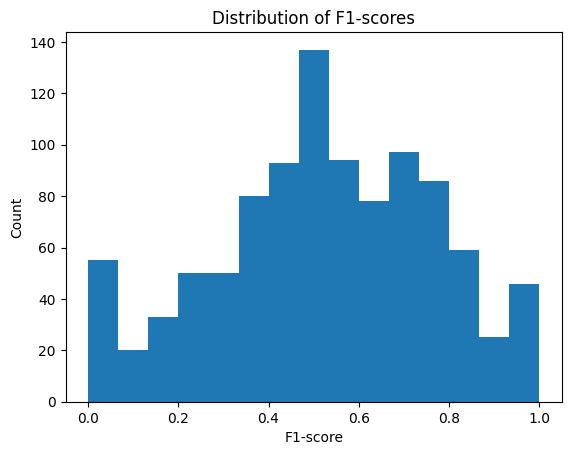

In [6]:
import time
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

# Prepare data
X = data.drop(columns=["Most common outcome for Agent 1"])
y = data["Most common outcome for Agent 1"]

# Custom implementation of Leave-One-Out Cross-Validation
scores = []
rulesetWeights = []
featureImportance = {}

startTime = time.time()
noIterations = 0
noRulesets = rulesetIds.unique().shape[0]

for rulesetId in rulesetIds.unique():
    # Train/test split
    trainIdx = (rulesetIds != rulesetId)
    X_train = X[trainIdx]
    y_train = y[trainIdx]

    testIdx = (rulesetIds == rulesetId)
    X_test = X[testIdx]
    y_test = y[testIdx]

    # Train classifier
    clf = DecisionTreeClassifier().fit(X_train, y_train, sample_weight=weights[trainIdx])

    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Determine performance of classifier
    scores.append(f1_score(y_test, y_pred, average="weighted"))
    
    # Log other important information
    rulesetWeights.append(weights[testIdx].iloc[0])
    featureImportance[rulesetId] = clf.feature_importances_
    
    # Output progress
    noIterations += 1
    if noIterations % 50 == 0:
        elapsedTime = time.time() - startTime
        avgTimePerIteration = elapsedTime / noIterations
        print(f"Progress: {noIterations}/{noRulesets}; Time elapsed (s): {elapsedTime:.2f}; Estimated time left (s): {(noRulesets - noIterations) * avgTimePerIteration:.2f}")

print(f"Progress: {noIterations}/{noRulesets}; Time elapsed (s): {time.time() - startTime:.2f}")

# Output results
print(f"\n-- Results (F1-score) --")
print(f"Minimum: {np.min(scores):.3f}\nMaximum: {np.max(scores):.3f}")
print(f"\nUnweighted average: {np.average(scores):.3f}\n  Weighted average: {np.average(scores, weights=rulesetWeights):.3f}")
print(f"\nUnweighted standard deviation: {np.std(scores):.3f}\n  Weighted standard deviation: {np.sqrt(np.cov(scores, aweights=rulesetWeights)):.3f}")
 
plt.hist(scores, bins=15)
plt.xlabel("F1-score")
plt.ylabel("Count")
plt.title("Distribution of F1-scores");

In [7]:
import pandas as pd

featureImportance = pd.DataFrame.from_dict(featureImportance, orient="index", columns=X.columns)

# Rank features from most to least important
avgFeatureImportance = pd.Series(np.average(featureImportance, axis=0, weights=rulesetWeights), index=featureImportance.columns)
order = avgFeatureImportance.argsort()
avgFeatureImportance.iloc[order[::-1]]

Exploration 1           3.872359e-02
NumColumns              3.869986e-02
Exploration 2           3.581637e-02
Play-out 1 - Random0    3.495740e-02
Play-out 2 - Random0    2.600365e-02
                            ...     
LeftwardsDirection      4.209763e-21
Play-out 2 - Random     0.000000e+00
Selection 2 - Random    0.000000e+00
Play-out 1 - Random     0.000000e+00
Selection 1 - Random    0.000000e+00
Length: 184, dtype: float64

In [8]:
# Adding weights:
# (V) Add weights to training of classifier
# (V) Compute weighted average of f1-score
# (V) Compute weighted standard deviation of f1-score (?)
# (V) Change from unweighted to weighted average feature importance